In [1]:
import re
import csv
import nltk
import math
import operator
import numpy as np
import pandas as pd 
from tqdm import tqdm
from collections import Counter
from scipy.stats.kde import gaussian_kde
import sklearn
import sklearn.metrics as metrics
from nltk.data import find
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
nltk.download('vader_lexicon')
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download('wordnet')

C:\Anaconda\envs\py35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to C:\Windows\ServicePro
[nltk_data]     files\LocalService\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Windo
[nltk_data]     ws\ServiceProfiles\LocalService\AppData\Roaming\nltk_d
[nltk_data]     ata...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to C:\Windows\ServiceProfiles\
[nltk_data]     LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Q1. Sentiment Analysis and Aggregation

## Q1 (a)

In [2]:
data = pd.read_csv('reviews.csv', header=None)
data.columns=['idNum','filePath','hotelName','reviewCol','ratingScore','groundTruth']
data.head()

,idNum,filePath,hotelName,reviewCol,ratingScore,groundTruth
0,114908371,data\ca\154954\1009148\114961694.html,Canad Inns Destination Centre Fort Garry,The Canad Inn Fort Gary has it all: restaurant...,4,positive
1,114961694,data\ca\154954\1009148\115337572.html,Canad Inns Destination Centre Fort Garry,We booked a family theme room at the Canad Inn...,5,positive
2,115337572,data\ca\154954\1009148\115992713.html,Canad Inns Destination Centre Fort Garry,Our family has stayed several times in this ho...,5,positive
3,115992713,data\ca\154954\1009148\116263389.html,Canad Inns Destination Centre Fort Garry,we had a nice room w two queen beds and a flat...,4,positive
4,119296789,data\ca\154954\1009148\122124811.html,Canad Inns Destination Centre Fort Garry,"From reception to the quiet, clean, comfortabl...",4,positive


In [3]:
def evalSentences(df, columns=[]):
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    for index, row in df.iterrows():
        ss = sid.polarity_scores(str(row['reviewCol']))
        pdlist.append([row['hotelName']]+[row['reviewCol']]+[ss['compound']]+[row['ratingScore']]+[row['groundTruth']])
    reviewDf = pd.DataFrame(pdlist)
    reviewDf.columns = columns
    return reviewDf

In [4]:
reviewDF = evalSentences(data, columns=['hotelName', 'reviewCol', 'vader', 'rating', 'groundTruth'])
count = reviewDF.hotelName.value_counts()
reviewDF = reviewDF.loc[reviewDF['hotelName'].isin(count[count>3].index)]
reviewDF.head()

,hotelName,reviewCol,vader,rating,groundTruth
0,Canad Inns Destination Centre Fort Garry,The Canad Inn Fort Gary has it all: restaurant...,0.6588,4,positive
1,Canad Inns Destination Centre Fort Garry,We booked a family theme room at the Canad Inn...,0.9983,5,positive
2,Canad Inns Destination Centre Fort Garry,Our family has stayed several times in this ho...,0.9682,5,positive
3,Canad Inns Destination Centre Fort Garry,we had a nice room w two queen beds and a flat...,0.9482,4,positive
4,Canad Inns Destination Centre Fort Garry,"From reception to the quiet, clean, comfortabl...",0.6912,4,positive


In [5]:
ranksdf = reviewDF[['hotelName', 'vader', 'rating']]
ranks = reviewDF.groupby(['hotelName']).mean().reset_index()
ranks.head()

,hotelName,vader,rating
0,Airport Motor Inn,-0.603775,1.000000
1,Best Western Plus Downtown Winnipeg,0.716912,4.176471
2,Best Western Plus Pembina Inn & Suites,0.934356,4.719298
3,Best Western Plus Winnipeg Airport Hotel,0.809716,4.368421
4,Canad Inns Destination Centre Club Regent Casi...,0.825900,3.571429


## Q1 (b)

In [6]:
ranks.nlargest(5, 'vader')

,hotelName,vader,rating
34,Mariaggi\'s Theme Suite Hotel & Spa,0.937940,3.800000
2,Best Western Plus Pembina Inn & Suites,0.934356,4.719298
14,"Country Inn & Suites By Carlson, Winnipeg, MB",0.922711,3.888889
9,Canad Inns Garden City,0.889079,4.357143
28,Holiday Inn Winnipeg Airport - Polo Park,0.886840,4.400000


In [7]:
ranks.nsmallest(5, 'vader')

,hotelName,vader,rating
0,Airport Motor Inn,-0.603775,1.000000
47,Winnipeg Thriftlodge,-0.001733,1.857143
16,"Days Inn & Suites Winnipeg Airport, Manitoba",0.147395,3.545455
41,Sandman Hotel & Suites Winnipeg Airport,0.211175,3.500000
44,The Marlborough Hotel,0.270672,2.689655


In [8]:
ranks.nlargest(5, 'rating')

,hotelName,vader,rating
36,Norwood Hotel,0.857744,4.888889
15,Courtyard Winnipeg Airport,0.853429,4.791667
2,Best Western Plus Pembina Inn & Suites,0.934356,4.719298
43,The Grand Winnipeg Airport Hotel,0.872308,4.677966
24,Hampton Inn by Hilton Winnipeg Airport\/Polo Park,0.850982,4.676768


In [9]:
ranks.nsmallest(5, 'rating')

,hotelName,vader,rating
0,Airport Motor Inn,-0.603775,1.000000
47,Winnipeg Thriftlodge,-0.001733,1.857143
44,The Marlborough Hotel,0.270672,2.689655
7,Canad Inns Destination Centre Transcona,0.334908,2.750000
29,Holiday Inn Winnipeg South,0.533323,3.076923


## Q2. Frequency Analysis

## Q2 (a)

In [10]:
stop = set(stopwords.words('english'))
stop.update(('hotel', 're', 'pm', 'am', 'of', 'from', 'would', 'could', 'also'))
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', str(review)) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [11]:
reviewsd = reviewDF[['reviewCol', 'vader', 'groundTruth']]

In [12]:
topkGroundPos = getTopK(df=reviewsd, k=50, label_value='positive')
topkGroundPos

[('room', 1164),
 ('staff', 769),
 ('great', 746),
 ('stay', 727),
 ('clean', 537),
 ('nice', 533),
 ('good', 519),
 ('winnipeg', 508),
 ('rooms', 469),
 ('breakfast', 448),
 ('stayed', 402),
 ('friendly', 381),
 ('service', 369),
 ('comfortable', 364),
 ('well', 342),
 ('one', 341),
 ('airport', 337),
 ('restaurant', 328),
 ('pool', 312),
 ('location', 281),
 ('night', 273),
 ('time', 259),
 ('area', 255),
 ('helpful', 246),
 ('excellent', 245),
 ('desk', 239),
 ('bed', 239),
 ('food', 234),
 ('close', 213),
 ('front', 209),
 ('place', 207),
 ('free', 200),
 ('parking', 197),
 ('like', 195),
 ('get', 191),
 ('beds', 183),
 ('coffee', 182),
 ('really', 181),
 ('back', 177),
 ('always', 174),
 ('walk', 167),
 ('best', 162),
 ('check', 162),
 ('recommend', 159),
 ('new', 156),
 ('definitely', 154),
 ('forks', 152),
 ('downtown', 147),
 ('quiet', 147),
 ('everything', 145)]

In [13]:
topkGroundNeg = getTopK(df=reviewsd, k=50, label_value='negative')
topkGroundNeg

[('room', 508),
 ('stay', 179),
 ('night', 164),
 ('rooms', 158),
 ('desk', 158),
 ('staff', 143),
 ('good', 141),
 ('one', 135),
 ('front', 132),
 ('stayed', 121),
 ('nice', 111),
 ('clean', 109),
 ('get', 108),
 ('time', 95),
 ('place', 95),
 ('breakfast', 94),
 ('bed', 93),
 ('service', 92),
 ('pool', 86),
 ('well', 81),
 ('area', 81),
 ('like', 78),
 ('great', 78),
 ('told', 77),
 ('bathroom', 76),
 ('parking', 75),
 ('floor', 74),
 ('even', 74),
 ('winnipeg', 72),
 ('restaurant', 70),
 ('next', 70),
 ('back', 69),
 ('day', 68),
 ('first', 65),
 ('food', 65),
 ('really', 64),
 ('check', 61),
 ('small', 59),
 ('people', 59),
 ('morning', 59),
 ('old', 58),
 ('never', 57),
 ('booked', 57),
 ('door', 57),
 ('got', 56),
 ('around', 54),
 ('little', 53),
 ('said', 52),
 ('asked', 52),
 ('found', 51)]

## Q2 (b)

In [14]:
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
pos_tag = PerceptronTagger().tag
chunker = nltk.RegexpParser(grammar)

# Noun Phrase Extraction Support Functions
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term
            
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [15]:
def topphrase(df, k, label_value):
    # Top-k frequent terms
    counter = Counter()
    for review in df.loc[operator.eq(df['groundTruth'],label_value)]['reviewCol']:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review))))) 
                            ]))
    topk = counter.most_common(k)   
    return topk

In [16]:
topkGroundPos = topphrase(df=reviewsd, k=50, label_value='positive')
topkGroundPos

[('front desk', 82),
 ('fort garri', 46),
 ('hot tub', 41),
 ('front desk staff', 32),
 ('pool area', 32),
 ('great locat', 31),
 ('room servic', 31),
 ('great place', 28),
 ('fort garri hotel', 26),
 ('minut walk', 24),
 ('hotel staff', 23),
 ('great hotel', 22),
 ('nice hotel', 22),
 ('comfort bed', 21),
 ('continent breakfast', 20),
 ('winnipeg airport', 20),
 ('great experi', 19),
 ('first time', 18),
 ('next time', 18),
 ('next morn', 17),
 ('busi trip', 16),
 ('short walk', 16),
 ('downtown winnipeg', 16),
 ('airport hotel', 15),
 ('friendli staff', 15),
 ('great servic', 15),
 ('sunday brunch', 14),
 ('victoria inn', 14),
 ('good food', 14),
 ('human right museum', 14),
 ('nice touch', 14),
 ('hotel restaur', 14),
 ('coffe maker', 14),
 ('holiday inn', 14),
 ('great stay', 13),
 ('great view', 13),
 ('hotel room', 13),
 ('custom servic', 12),
 ('busi travel', 12),
 ('complimentari breakfast', 12),
 ('exchang district', 12),
 ('polo park', 12),
 ('free shuttl', 12),
 ('good locat

In [17]:
topkGroundPos = topphrase(df=reviewsd, k=50, label_value='negative')
topkGroundPos

[('front desk', 56),
 ('hot tub', 14),
 ('next day', 13),
 ('front desk staff', 13),
 ('pool area', 12),
 ('room servic', 9),
 ('first night', 9),
 ('fort garri', 9),
 ('park lot', 9),
 ('next morn', 8),
 ('canad inn', 7),
 ('credit card', 7),
 ('hotel room', 7),
 ('next time', 6),
 ('first time', 6),
 ('room rate', 6),
 ('good thing', 6),
 ('mt centr', 6),
 ('desk clerk', 6),
 ('hotel staff', 6),
 ('lobbi area', 5),
 ('front desk clerk', 5),
 ('drunk peopl', 5),
 ('continent breakfast', 5),
 ('ground floor', 5),
 ('free park', 5),
 ('clean staff', 5),
 ('marlborough hotel', 5),
 ('bad experi', 5),
 ('earli flight', 5),
 ('breakfast buffet', 4),
 ('hot water', 4),
 ('last stay', 4),
 ('stone wall', 4),
 ('last night', 4),
 ('littl bit', 4),
 ('half hour', 4),
 ('king room', 4),
 ('room key', 4),
 ('second floor', 4),
 ('theme suit', 4),
 ('fort garri hotel', 4),
 ('busi travel', 4),
 ('mt center', 4),
 ('second time', 4),
 ('minut walk', 3),
 ('internet access', 3),
 ('good size', 3),


## Q3. Mutual Information

## Q3 (a)

In [18]:
def dataFrameTransformation(hotelDf, k):
    reviews = hotelDf['reviewCol'].as_matrix()
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', str(review))
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',str(reviews[i]))])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf = hotelDf[['hotelName', 'rating', 'groundTruth', 'reviewCol', 'vader']].join(freqReviewDf)
    return topk, finaldf

In [19]:
topk, finaldf = dataFrameTransformation(reviewDF, k=500)

In [20]:
def getMI(topk, df, label_column='groundTruth'):
    truth = df['groundTruth']
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(truth, df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MIScore']
    return miScoredf

In [21]:
miScoredf = getMI(topk, finaldf)

In [22]:
miScoredf.nlargest(50, 'MIScore')

,Word,MIScore
342,dirty,0.008361
171,super,0.006882
101,work,0.006181
257,needs,0.005937
246,nan,0.005864
1,staff,0.005593
19,desk,0.005551
61,forks,0.005507
432,choose,0.005384
20,airport,0.005354


## Q3 (b)

In [23]:
def phraseTransformation(df, k):
    reviews = df['reviewCol'].as_matrix()
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
        counter.update(flatten([word
                        for word 
                        in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review))))) 
                        ]))
    topk = counter.most_common(k)   
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',str(reviews[i])))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = df[['hotelName', 'rating', 'groundTruth', 'reviewCol', 'vader']].join(freqReviewDf)
    return topk, finaldf

In [24]:
topphrase, phrasedf = phraseTransformation(reviewDF, k=500)

In [25]:
miPhrases = getMI(topphrase, phrasedf)

In [27]:
miPhrases.nlargest(50, 'MIScore')

,Word,MIScore
143,star hotel,0.005625
285,park area,0.004679
291,multipl time,0.004679
326,short cab ride,0.004679
48,nice place,0.004583
61,great time,0.004543
89,good place,0.004247
87,credit card,0.004110
222,great sleep,0.004110
193,follow day,0.004110


## Q4. Pointwise Mutual Information

## Q4 (a)

In [28]:
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log10((pxy+0.0001)/(px*py))
            else:
                pmi = math.log10(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log10((pxy+0.0001)/(px*py))
    else:
        pmi = math.log10(pxy/(px*py))
    return pmi

def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pd.DataFrame(pmilist)
    pmiposlist = pd.DataFrame(pmiposlist)
    pmineglist = pd.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [29]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(finaldf, topk=topk)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.83it/s]


In [30]:
wmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
481,churchill,0.082541
171,super,0.072996
460,soft,0.065508
294,thanks,0.061948
345,brunch,0.061143
352,charge,0.060014
383,plenty,0.058815
291,hard,0.057539
276,points,0.055466
312,fast,0.055466


In [31]:
wmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
342,dirty,0.416275
496,star,0.334428
432,choose,0.305625
257,needs,0.272832
425,hallway,0.265007
246,nan,0.262546
309,continental,0.258667
445,phone,0.255247
450,slow,0.251643
379,probably,0.248617


## Q4 (b)

In [32]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrasedf, topk=topphrase)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  7.00it/s]


In [33]:
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
61,great time,0.098932
373,effici room,0.098932
180,pleasant stay,0.098932
364,great start,0.098932
358,extra night,0.098932
169,complimentari coffe,0.098932
170,earli check,0.098932
357,sever restaur,0.098932
354,hot room,0.098932
352,excel stay,0.098932


In [34]:
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
449,bed sheet,0.690976
379,kid theme room,0.690976
285,park area,0.566037
326,short cab ride,0.566037
291,multipl time,0.566037
143,star hotel,0.544848
455,clean bathroom,0.514885
329,convent centr,0.514885
356,quick snack,0.514885
464,mani year,0.514885


## Q4 (c)

In [35]:
tophoteldf = reviewDF.loc[reviewDF['hotelName'] == 'Norwood Hotel'].reset_index()
bottomhoteldf = reviewDF.loc[reviewDF['hotelName'] == 'Airport Motor Inn'].reset_index()

In [36]:
topk_top, finaldf_top = dataFrameTransformation(tophoteldf, k=80)
topk_bot, finaldf_bot = dataFrameTransformation(bottomhoteldf, k=80)
topphrase_top, phrasedf_top = phraseTransformation(tophoteldf, k=80)
topphrase_bot, phrasedf_bot = phraseTransformation(bottomhoteldf, k=80)

### For top hotel Norwood Hotel

In [37]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(finaldf_top, topk=topk_top)
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrasedf_top, topk=topphrase_top)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.00it/s]


In [38]:
wmiposlist.sort_values('pmi',ascending=0).head(10)

,word,pmi
0,norwood,0.0
1,location,0.0
58,went,0.0
57,tired,0.0
56,big,0.0
55,within,0.0
54,hungry,0.0
53,used,0.0
52,mention,0.0
51,regardless,0.0


In [39]:
wmineglist.sort_values('pmi',ascending=0).head(10)

,word,pmi
0,norwood,inf
1,location,inf
58,went,inf
57,tired,inf
56,big,inf
55,within,inf
54,hungry,inf
53,used,inf
52,mention,inf
51,regardless,inf


In [40]:
pmiposlist.sort_values('pmi',ascending=0).head(10)

,word,pmi
0,pleasant colour,0.0
28,usual expect,0.0
21,pleasant surpris,0.0
22,help pleasant,0.0
23,norwood mani time,0.0
24,winter vacat,0.0
25,charm neighborhood,0.0
26,reason rate,0.0
27,date larg room,0.0
29,hotel restaur,0.0


In [41]:
pmineglist.sort_values('pmi',ascending=0).head(10)

,word,pmi
0,pleasant colour,inf
28,usual expect,inf
21,pleasant surpris,inf
22,help pleasant,inf
23,norwood mani time,inf
24,winter vacat,inf
25,charm neighborhood,inf
26,reason rate,inf
27,date larg room,inf
29,hotel restaur,inf


### For bottom hotel Airport Motor Inn

In [42]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(finaldf_bot, topk=topk_bot)
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrasedf_bot, topk=topphrase_bot)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.11it/s]


In [43]:
wmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,room,inf
1,people,inf
58,came,inf
57,parties,inf
56,area,inf


In [44]:
wmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,room,0.0
1,people,0.0
58,came,0.0
57,parties,0.0
56,area,0.0


In [45]:
pmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,front desk,inf
44,first night,inf
50,differ level,inf
49,crap attitud,inf
48,threadbar carpet,inf


In [46]:
pmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,front desk,0.0
44,first night,0.0
50,differ level,0.0
49,crap attitud,0.0
48,threadbar carpet,0.0


No. For the top rated hotel, all reviews are positive, and for the bottom hotel, all reviews are negative, so possibility of a review being positive or negative would be either 0 or 1, and PMI would be Inf or 0. Thus, words can't be ranked by PMI. 

## Q5. General Plots

## Q5 (a)

In [47]:
ranks['numreviews'] = (reviewDF.hotelName.value_counts().reset_index().sort_values(['index'],ascending=[True]))['hotelName'].values

In [48]:
ranks5 = ranks.sort_values('rating', ascending=False)

histograms of ground truth

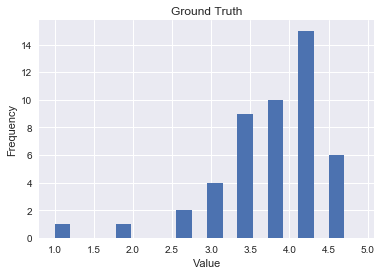

In [50]:
plt.hist(ranks5['rating'].as_matrix(), width=0.2)
plt.title('Ground Truth')
plt.xlabel('Value')
plt.ylabel('Frequency')
fig = plt.gcf()

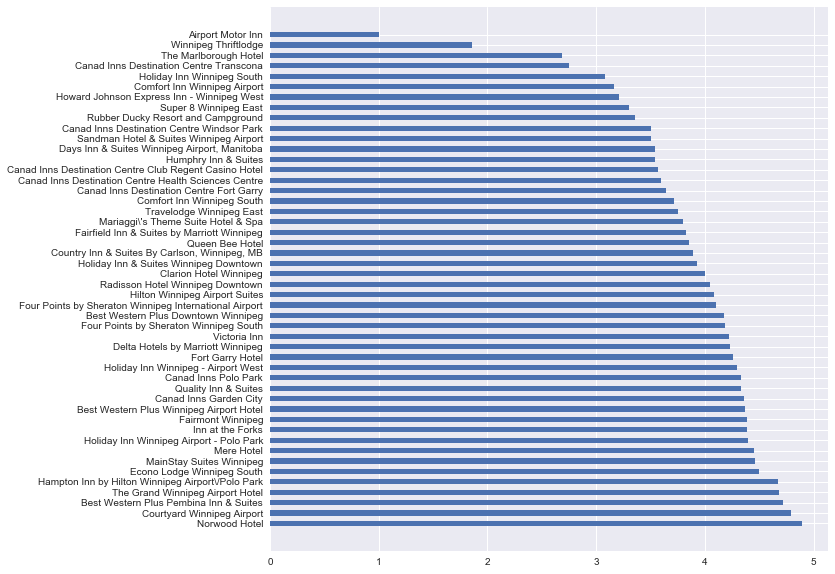

In [51]:
plt.figure(figsize=(10,10))
plt.barh(range(len(ranks5['rating'])), ranks5['rating'], tick_label=ranks5['hotelName'], height = 0.5)
plt.show()

histograms of Vader sentiment scores

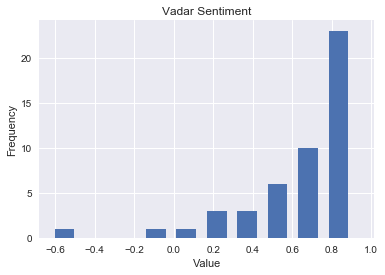

In [53]:
plt.hist(ranks5['vader'].as_matrix(), width=0.1)
plt.title('Vadar Sentiment')
plt.xlabel('Value')
plt.ylabel('Frequency')
fig = plt.gcf()

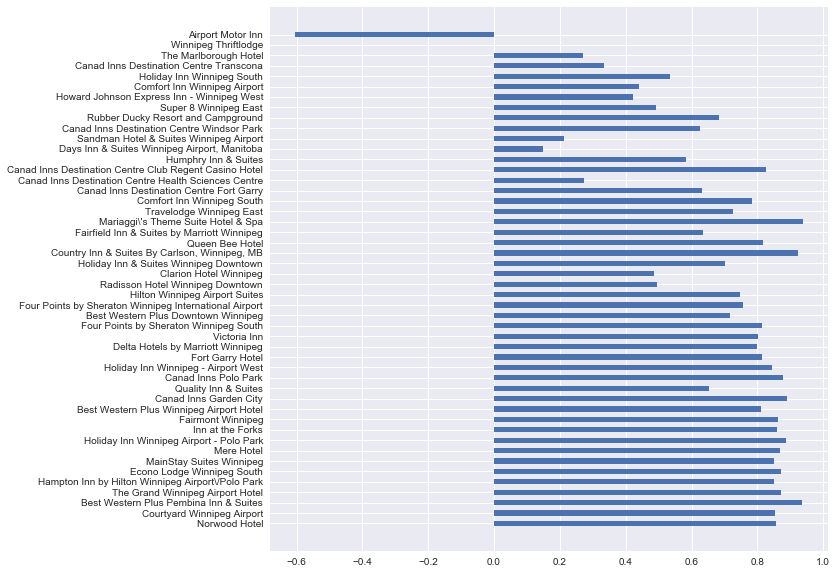

In [54]:
plt.figure(figsize=(10,10))
plt.barh(range(len(ranks5['vader'])), ranks5['vader'], tick_label=ranks5['hotelName'], height = 0.5)
plt.show()

histogram of the number of reviews per hotel

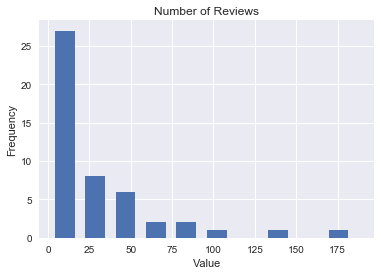

In [58]:
plt.hist(ranks5['numreviews'].as_matrix(), width=12)
plt.title('Number of Reviews')
plt.xlabel('Value')
plt.ylabel('Frequency')
fig = plt.gcf()

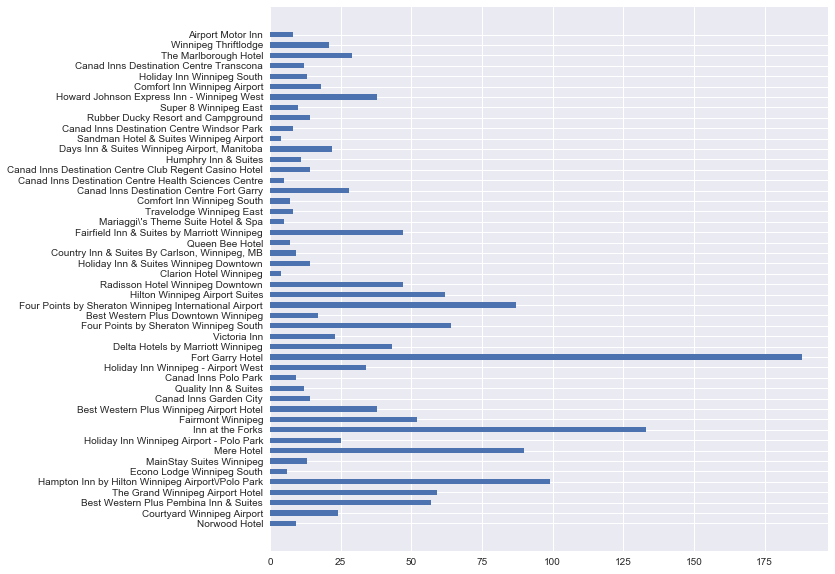

In [59]:
plt.figure(figsize=(10,10))
plt.barh(range(len(ranks5['numreviews'])), ranks5['numreviews'], tick_label=ranks5['hotelName'], height = 0.5)
plt.show()

Hotels with low ratings do not have many reviews and hotels with few reviews are more likely to have inaccurate vader scores.

Vader score for Mariaggi's Theme Suite Hotel & Spa should be lower according to ratings.
Vader score for Clarion Hotel Winnipeg should be higher according to ratings.
Vader score for Sandman Hotel & Suites Winnipeg Airport should be higher according to ratings.

## Q5 (b)

In [60]:
tp5gthotel = ranks.sort_values('rating',ascending=0).head(5)
tp5gthotel

,hotelName,vader,rating,numreviews
36,Norwood Hotel,0.857744,4.888889,9
15,Courtyard Winnipeg Airport,0.853429,4.791667,24
2,Best Western Plus Pembina Inn & Suites,0.934356,4.719298,57
43,The Grand Winnipeg Airport Hotel,0.872308,4.677966,59
24,Hampton Inn by Hilton Winnipeg Airport\/Polo Park,0.850982,4.676768,99


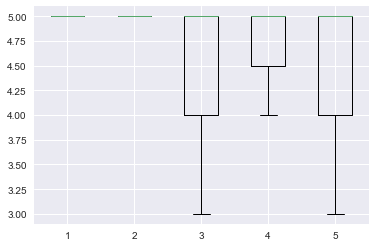

In [61]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ranks.sort_values('rating',ascending=0).head(5)

norwood = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['rating']
courtyard = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['rating']
bestwes = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['rating']
grand = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['rating']
hampton = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['rating']

data = [norwood, courtyard, bestwes, grand, hampton]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

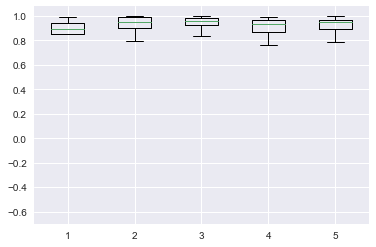

In [62]:
vnorwood = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['vader']
vcourtyard = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['vader']
vbestwes = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['vader']
vgrand = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['vader']
vhampton = reviewDF.loc[reviewDF['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['vader']

data = [vnorwood, vcourtyard, vbestwes, vgrand, vhampton]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [63]:
print('For ground truth star rating,\n')
print('Norwood Hotel:      mean {}, variance {}'.format(np.array(norwood).mean(), np.array(norwood).var()))
print('Courtyard Winnipeg: mean {}, variance {}'.format(np.array(courtyard).mean(), np.array(courtyard).var()))
print('Best Western Plus : mean {}, variance {}'.format(np.array(bestwes).mean(), np.array(bestwes).var()))
print('Grand Winnipeg:     mean {}, variance {}'.format(np.array(grand).mean(), np.array(grand).var()))
print('Hampton Inn:        mean {}, variance {}'.format(np.array(hampton).mean(), np.array(hampton).var()))

For ground truth star rating,

Norwood Hotel:      mean 4.888888888888889, variance 0.09876543209876544
Courtyard Winnipeg: mean 4.791666666666667, variance 0.16493055555555558
Best Western Plus : mean 4.719298245614035, variance 0.23699599876885197
Grand Winnipeg:     mean 4.677966101694915, variance 0.3539212869864982
Hampton Inn:        mean 4.6767676767676765, variance 0.2591572288541985


In [64]:
print('For Vader sentiment scores,\n')
print('Norwood Hotel:      mean {}, variance {}'.format(np.array(vnorwood).mean(), np.array(vnorwood).var()))
print('Courtyard Winnipeg: mean {}, variance {}'.format(np.array(vcourtyard).mean(), np.array(vcourtyard).var()))
print('Best Western Plus : mean {}, variance {}'.format(np.array(vbestwes).mean(), np.array(vbestwes).var()))
print('Grand Winnipeg:     mean {}, variance {}'.format(np.array(vgrand).mean(), np.array(vgrand).var()))
print('Hampton Inn:        mean {}, variance {}'.format(np.array(vhampton).mean(), np.array(vhampton).var()))

For Vader sentiment scores,

Norwood Hotel:      mean 0.8577444444444444, variance 0.02608718024691358
Courtyard Winnipeg: mean 0.8534291666666668, variance 0.07285585456597223
Best Western Plus : mean 0.934356140350877, variance 0.0060238515851031085
Grand Winnipeg:     mean 0.872308474576271, variance 0.03809088111462223
Hampton Inn:        mean 0.8509818181818181, variance 0.07454537320477503


Boxplots are more informative for scores of some hotels, since mean and variance are more suitable for symmetrically distributed data and some scores are not. The boxplots show minimum, maximum, median, first quartile, third quartile, skewness of data.

## Q5 (c)

## Q5 (c) (a)

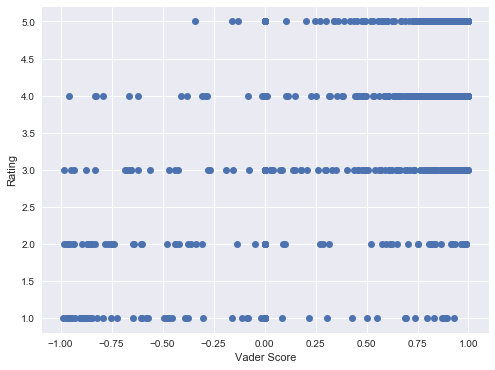

In [65]:
plt.figure(figsize=(8,6))
y = reviewDF['rating'].as_matrix()
x = reviewDF['vader'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

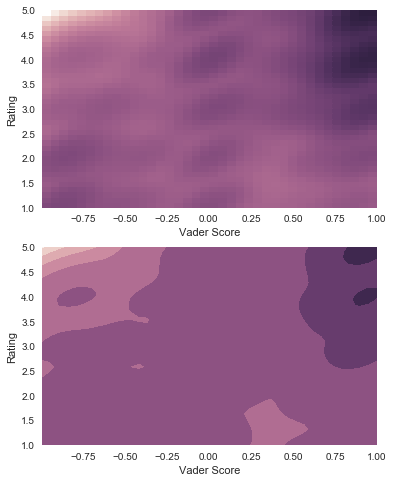

In [66]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

In [67]:
heatmap, yedges, xedges = np.histogram2d(x, y, bins=10)
heatmap1, yedges, xedges = np.histogram2d(x, y, bins=9)
ht = heatmap/heatmap.sum(axis=0)
ht[np.isnan(ht)] = 0

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


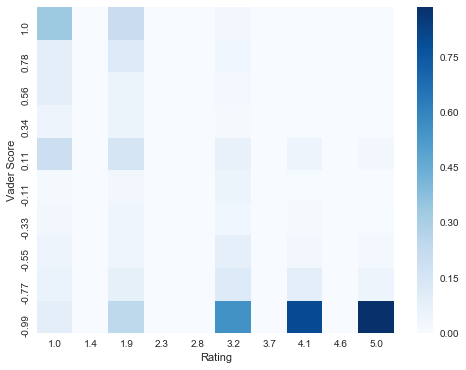

In [68]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(ht, cmap="Blues", vmin=0)
ax.set_xticklabels(np.around(xedges, decimals=1))
ax.set_yticklabels(np.around(yedges, decimals=2))
ax.set_ylabel('Vader Score') 
ax.set_xlabel('Rating') 
plt.show()

When rantings are 3 or 4 or 5, most of vader scores are close to 1. 

When rantings are 1, most of vader scores are below 0.

## Q5 (c) (b)

In [69]:
reviewDF['len'] = reviewDF['reviewCol'].str.len()
reviewDF['len'] = reviewDF['len'].fillna(0.0).astype(int)

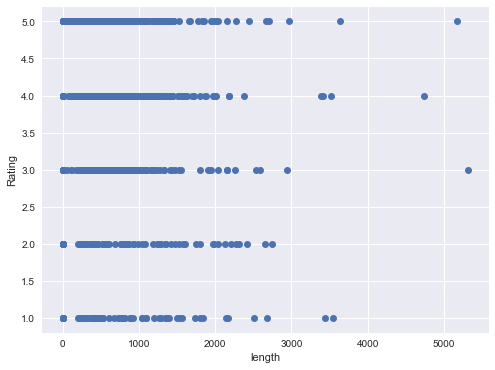

In [70]:
plt.figure(figsize=(8,6))
y = reviewDF['rating'].as_matrix()
x = reviewDF['len'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('length')

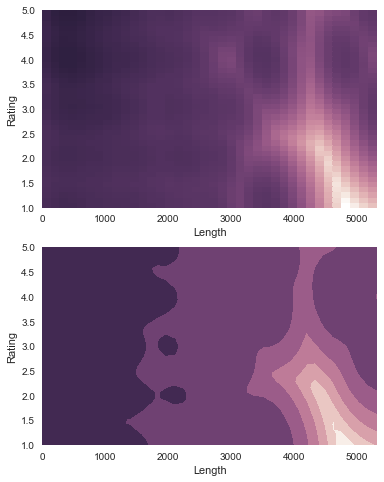

In [71]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Length')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Length')
ax2.set_ylabel('Rating')

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


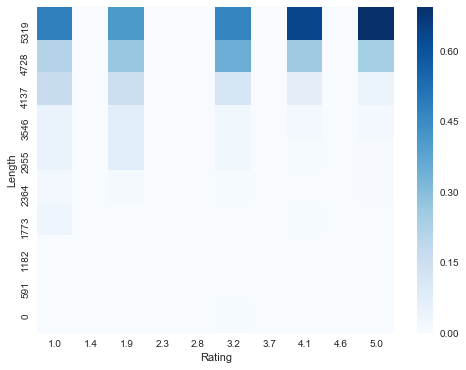

In [72]:
heatmap, yedges, xedges = np.histogram2d(x, y, bins=10)
heatmap1, yedges, xedges = np.histogram2d(x, y, bins=9)
ht = heatmap/heatmap.sum(axis=0)
ht[np.isnan(ht)] = 0

plt.figure(figsize=(8, 6))
ax = sns.heatmap(ht, cmap="Blues", vmin=0)
ax.set_xticklabels(np.around(xedges, decimals=1))
ax.set_yticklabels(yedges.astype(int))
ax.set_ylabel('Length') 
ax.set_xlabel('Rating') 
plt.show()

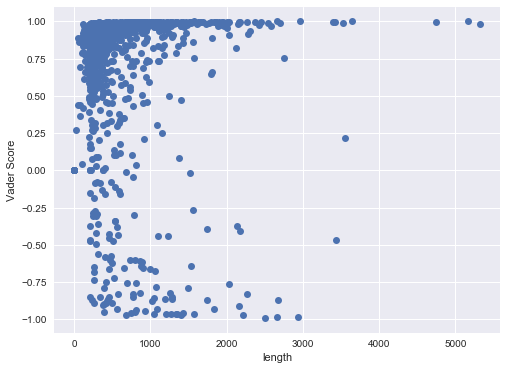

In [73]:
plt.figure(figsize=(8,6))
y = reviewDF['vader'].as_matrix()
x = reviewDF['len'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Vader Score')
plt.xlabel('length')

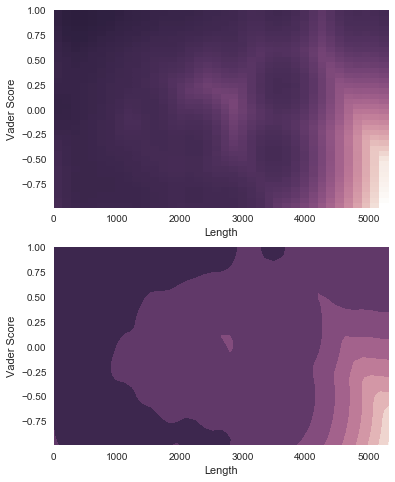

In [74]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Length')
ax1.set_ylabel('Vader Score')

ax2.set_xlabel('Length')
ax2.set_ylabel('Vader Score')

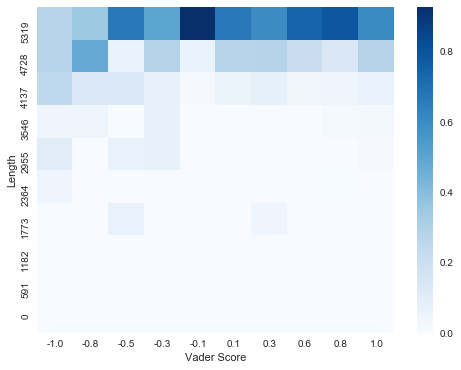

In [75]:
heatmap, yedges, xedges = np.histogram2d(x, y, bins=10)
heatmap1, yedges, xedges = np.histogram2d(x, y, bins=9)
ht = heatmap/heatmap.sum(axis=0)
ht[np.isnan(ht)] = 0

plt.figure(figsize=(8, 6))
ax = sns.heatmap(ht, cmap="Blues", vmin=0)
ax.set_xticklabels(np.around(xedges, decimals=1))
ax.set_yticklabels(yedges.astype(int))
ax.set_ylabel('Length') 
ax.set_xlabel('Vader Score') 
plt.show()

Most of reviews are with length less than 1000.

## Q5 (c) (c)

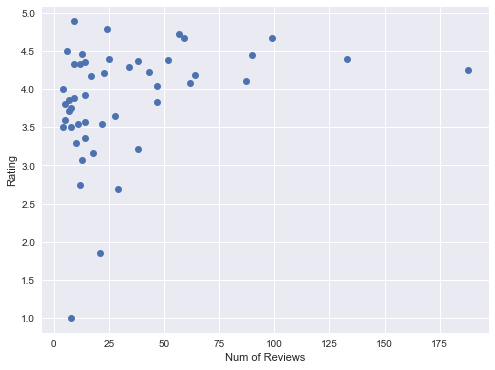

In [76]:
plt.figure(figsize=(8,6))
y = ranks['rating'].as_matrix()
x = ranks['numreviews'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Num of Reviews')

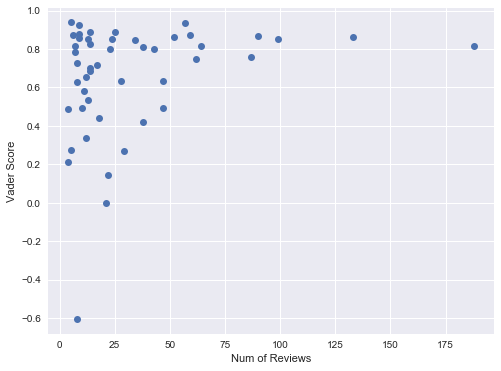

In [77]:
plt.figure(figsize=(8,6))
y = ranks['vader'].as_matrix()
x = ranks['numreviews'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Vader Score')
plt.xlabel('Num of Reviews')

Most of hotels are with average rating more than 3, vader score more than 0, and number of reviews less than 100.